In [1]:
import gym
from gym import spaces
import numpy as np
from google.colab import widgets
import time
import random
from collections import deque
import copy
from statistics import mean
from itertools import count
from collections import namedtuple
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

# **Grid Environment**

In [2]:
class GridEnvironment(gym.Env):
  def __init__(self, environment_type):
    self.observation_space = spaces.Discrete(25)
    self.action_space = spaces.Discrete(4)
    self.max_timesteps = 75
    self.environment_type = environment_type

        
  def reset(self):
    self.timestep = 0
        
    self.agent_pos = [0, 0]
    self.goal_pos = [4, 4]
        
    self.p_1_pos = [1, 0]
    self.p_2_pos = [2, 2]
    self.p_3_pos = [2, 4]
    self.p_5_pos = [1, 4]
    self.p_6_pos = [2, 0]

    self.as_1_pos = [3, 3]
    self.as_2_pos = [1, 1]
    self.as_3_pos = [4, 2]
    self.as_4_pos = [0, 2]
    self.as_5_pos = [3, 0]
    self.as_6_pos = [2, 3] 

    self.state = np.zeros((5, 5))

    self.state[tuple(self.agent_pos)] = 1
    self.state[tuple(self.goal_pos)] = 0.8
        
    self.as_discount_factor = 1
    self.p_discount_factor = 1

    self.p_pos_rew_dict = {tuple(self.p_1_pos):1, tuple(self.p_2_pos):1, tuple(self.p_3_pos):1, tuple(self.p_5_pos):1, tuple(self.p_6_pos):1}
    self.as_pos_rew_dict = {tuple(self.as_1_pos):-1, tuple(self.as_2_pos):-1, tuple(self.as_3_pos):-1, tuple(self.as_4_pos):-1, tuple(self.as_5_pos):-1, tuple(self.as_6_pos):-1}
    
    for each_p_pos in self.p_pos_rew_dict:
      self.state[each_p_pos] = 0.4

    for each_as_pos in self.as_pos_rew_dict:
      self.state[each_as_pos] = 0.2
    #print(self.state)           
    observation = self.state.flatten()
    return observation
    
  def step(self, action):

    #self.state = np.random.choice(self.observation_space.n)

    if self.environment_type == "deterministic":
      if action == 0:
        self.agent_pos[0] += 1
        #print("Down")
      if action == 1:
        self.agent_pos[0] -= 1
           # print("Up")
      if action == 2:
        self.agent_pos[1] += 1
           # print("Right")
      if action == 3:
        self.agent_pos[1] -= 1
           # print("Left")
        
    elif self.environment_type == "stochastic":
          
      if action == 0:  #down
        action_performed = np.random.choice((0,1), p=[0.1, 0.9])
        if action_performed:              
          self.agent_pos[0] += 1
          print("Down")
        else:
          self.agent_pos[0] -= 1
          print("Down No, Up")

      if action == 1: #up
        action_performed = np.random.choice((0,1), p=[0.2, 0.8])
        if action_performed:
          self.agent_pos[0] -= 1
          # print("Up")
        else:
          self.agent_pos[0] += 1
        #  print("Up No, Down")

      if action == 2:  # right
        action_performed = np.random.choice((0,1), p=[0.3, 0.7])
        if action_performed:
          self.agent_pos[1] += 1
          # print("Right")
        else:
          self.agent_pos[1] -= 1
        #  print("Right No, Left")

      if action == 3: #left
        self.agent_pos[1] -= 1
      #  print("Left")
          
    self.agent_pos = np.clip(self.agent_pos, 0, 4)
    self.state = np.zeros((5,5))

    for p_pos in self.p_pos_rew_dict:
      if self.p_pos_rew_dict[p_pos]!=0:
        self.state[p_pos] = 0.4

    for as_pos in self.as_pos_rew_dict:
      self.state[as_pos] = 0.2
          
        
    self.state[tuple(self.goal_pos)] = 0.8
    self.state[tuple(self.agent_pos)] = 1
        
        
        
    if (tuple(self.agent_pos) in self.p_pos_rew_dict) and (self.p_pos_rew_dict[tuple(self.agent_pos)] > 0):
       reward = self.p_pos_rew_dict[tuple(self.agent_pos)]
       self.p_pos_rew_dict[tuple(self.agent_pos)] = 0
    elif tuple(self.agent_pos) in self.as_pos_rew_dict:
      reward = self.as_pos_rew_dict[tuple(self.agent_pos)]        
    elif tuple(self.agent_pos) == tuple(self.goal_pos):
      reward = 1
    else:
      reward=0

    for p_pos in self.p_pos_rew_dict:
      self.p_pos_rew_dict[p_pos] =  self.p_pos_rew_dict[p_pos] * self.p_discount_factor

    for as_pos in self.as_pos_rew_dict:
      self.as_pos_rew_dict[as_pos] = self.as_pos_rew_dict[as_pos] * self.as_discount_factor
            
    self.timestep += 1
    done = True if (self.timestep >= self.max_timesteps) or (self.agent_pos == self.goal_pos).all() else  False
        
    info = {}
    observation = self.state.flatten()
    return observation, reward, done, info
    
  def render(self):
    plt.imshow(self.state)

# Actor-Critic

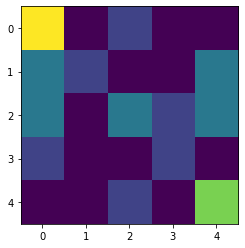

In [3]:
env = GridEnvironment(environment_type='deterministic')
env.reset()
env.render()

In [4]:
print("There are {} actions".format(env.action_space.n))

There are 4 actions


In [5]:
class ActorCritic(nn.Module):
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(25, 256)
        self.actor = nn.Linear(256, 4)
        self.critic = nn.Linear(256, 1)
        self.saved_actions = []
        self.rewards = []
    def forward(self, x):
        x = F.relu(self.fc1(x))
        action_prob = F.softmax(self.actor(x), dim=-1)
        state_values = self.critic(x)
        return action_prob, state_values

In [6]:
def select_action(state):
    state = torch.from_numpy(state).float()
    probs, state_value = model(state)
    m = Categorical(probs)
    action = m.sample()
    model.saved_actions.append(SavedAction(m.log_prob(action), state_value))
    return action.item()

In [7]:
def finish_episode():
    R = 0
    saved_actions = model.saved_actions
    policy_losses = []
    value_losses =[]
    returns = []
    
    for r in model.rewards[::-1]:
        R = r + 0.94 * R
        returns.insert(0, R)
    returns = torch.tensor(returns)
    returns = (returns - returns.mean()) / (returns.std() + eps)
    
    for (log_prob, value), R in zip(saved_actions, returns):
        advantage = R - value.item()
        
        policy_losses.append(-log_prob * advantage)
        value_losses.append(F.smooth_l1_loss(value, torch.tensor([R])))
    
    optimizer.zero_grad()
    loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
    
    loss.backward()
    optimizer.step()
    
    del model.rewards[:]
    del model.saved_actions[:]

In [8]:
model = ActorCritic()
optimizer = optim.Adam(model.parameters(), lr=9e-3)
eps = np.finfo(np.float32).eps.item()

In [9]:

SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])
RewardStats= []
for i_episode in range(1000):
    state = env.reset()
    Total_reward = 0
    for t in range(1, 75):
        action = select_action(state)
        state, reward, done, _ = env.step(action)
        model.rewards.append(reward)
        Total_reward+= reward
        if done:
            break
    RewardStats.append(Total_reward)
    finish_episode()
    if i_episode % 100 == 0:
        print("Episode {}\tLast Reward: {:.2f}\tAverage reward: {:.2f}".format(
            i_episode, Total_reward, mean(RewardStats[-100:])
        ))
    if mean(RewardStats[-100:]) >= 5.75:
        print("Solved, Average reward is now {} ".format(
                mean(RewardStats[-100:])
        ))
        break

Episode 0	Last Reward: -5.00	Average reward: -5.00
Episode 100	Last Reward: 6.00	Average reward: 1.75
Episode 200	Last Reward: 6.00	Average reward: 5.34
Solved, Average reward is now 5.75 


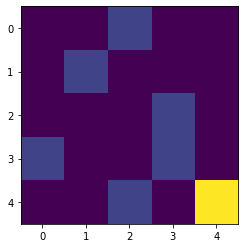

In [10]:
env.render()

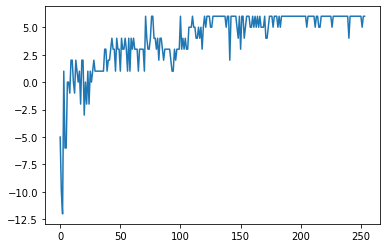

In [11]:
plt.plot(RewardStats)

In [12]:
test_rewards = []
for each_episode in range(10):
    obs = env.reset()
    done = False
    t=0
    total_reward = 0
    print("Episode : ", each_episode)

    while(not done):
        t += 1
        action = select_action(obs)
        obs, reward, done, _ = env.step(action)
        total_reward = total_reward + reward
        
    test_rewards.append(total_reward)
    print("Total Reward in this episode : ", total_reward)

Episode :  0
Total Reward in this episode :  6
Episode :  1
Total Reward in this episode :  6
Episode :  2
Total Reward in this episode :  6
Episode :  3
Total Reward in this episode :  6
Episode :  4
Total Reward in this episode :  6
Episode :  5
Total Reward in this episode :  6
Episode :  6
Total Reward in this episode :  6
Episode :  7
Total Reward in this episode :  6
Episode :  8
Total Reward in this episode :  6
Episode :  9
Total Reward in this episode :  6


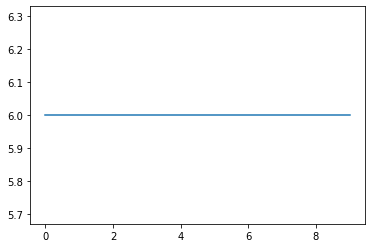

In [13]:
plt.plot(test_rewards)

In [14]:
from google.colab import files

torch.save(model, 'GRID_A2C_Checkpoint.pth')
files.download('GRID_A2C_Checkpoint.pth') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>